<a href="https://colab.research.google.com/github/lennymelnik/pb_dataChallenge/blob/master/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Predicting Returns

Team A

This Version was created by Leonard Melnik

### First I imported all the librarys that I will need



In [0]:
from datetime import datetime, timedelta,date
import pandas as pd
from scipy import stats
import math
from scipy.special import boxcox, inv_boxcox
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division

import warnings
warnings.filterwarnings("ignore")

#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Data Preprocessing
##### The Delivery Volume is a modified version of the data we were given. I removed the first three days because they lacked any substancial data and would pollute any results

##### I also decided to import the Dow Jones, just incase its data would prove its correlation

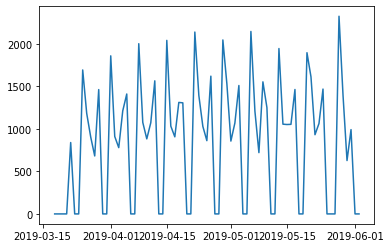

In [83]:
df_volume = pd.read_csv('https://raw.githubusercontent.com/lennymelnik/pb_dataChallenge/master/data/Delivery_Volume1.csv', index_col=['DELIVERY_DATE'], parse_dates=['DELIVERY_DATE'])
df_dji = pd.read_csv('https://raw.githubusercontent.com/lennymelnik/pb_dataChallenge/master/data/DJI.csv')


df_dji = df_dji.set_index('Date')

idx = pd.date_range('03-18-2019', '06-02-2019')
df_dji.index = pd.DatetimeIndex(df_dji.index)
df_dji = df_dji.reindex(idx, fill_value=0)

df_volume.sort_index(inplace=True)

df_volume['dji'] = df_dji['Adj Close']


df_volume=df_volume.fillna(0)
ts = df_volume['DELIVERED_VOLUME']
plt.plot(df_volume.index.values, df_volume['DELIVERED_VOLUME'])
plt.show()

# What I was able to understand from the data
If you look at the plot above, you can see that after there are no returns, there will always be a spike. And that spike is going to be the highest amount of returns that will happen that week.

The longer people cannot return products, the higher the spike will be. 

If you look at the last spike you can see it is much higher than the others. This is because it was memorial day weekend. Where people were unable to return anything for a longer period of time. So they had more saved up to return.

#Test If the Data is stationary

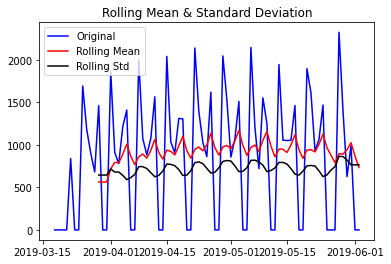

Results of Dickey-Fuller Test:
Test Statistic                 -4.205006
p-value                         0.000646
#Lags Used                      8.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [84]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(ts)


Test statistic is lower than the critial value. 

[   0.    0.    0.    0.  840.    0.    0. 1694. 1183.  905.  682. 1463.
    0.    0. 1860.  911.  780. 1213. 1411.    0.    0. 2003. 1077.  883.
 1073. 1566.    0.    0. 2042. 1033.  907. 1312. 1307.    0.    0. 2140.
 1394. 1030.  862. 1621.    0.    0. 2047. 1531.  857. 1070. 1511.    0.
    0. 2147. 1210.  721. 1554. 1251.    0.    0. 1946. 1056. 1052. 1054.
 1464.    0.    0. 1897. 1613.  932. 1064. 1469.    0.    0.    0. 2326.
 1398.  628.  992.    0.    0.]
DELIVERY_DATE
2019-03-18       0.0
2019-03-19       0.0
2019-03-20       0.0
2019-03-21       0.0
2019-03-22     840.0
               ...  
2019-05-29    1398.0
2019-05-30     628.0
2019-05-31     992.0
2019-06-01       0.0
2019-06-02       0.0
Name: DELIVERED_VOLUME, Length: 77, dtype: float64


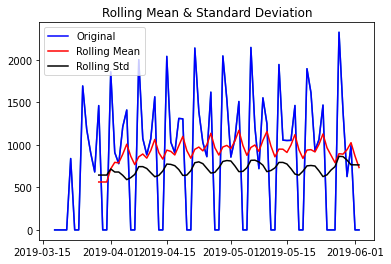

Results of Dickey-Fuller Test:
Test Statistic                 -4.205006
p-value                         0.000646
#Lags Used                      8.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64
DELIVERY_DATE
2019-03-18       0.0
2019-03-19       0.0
2019-03-20       0.0
2019-03-21       0.0
2019-03-22     840.0
2019-03-23       0.0
2019-03-24       0.0
2019-03-25    1694.0
2019-03-26    1183.0
2019-03-27     905.0
Name: DELIVERED_VOLUME, dtype: float64 DELIVERY_DATE
2019-03-18       NaN
2019-03-19       0.0
2019-03-20       0.0
2019-03-21       0.0
2019-03-22       0.0
2019-03-23     840.0
2019-03-24       0.0
2019-03-25       0.0
2019-03-26    1694.0
2019-03-27    1183.0
Name: DELIVERED_VOLUME, dtype: float64


ValueError: ignored

In [121]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
print(ts.values)
ts_sqrt = ts 
print(ts_sqrt)
plt.plot(ts_sqrt)
test_stationarity(ts_sqrt)
ts_diff = ts_sqrt - ts_sqrt.shift()
print(ts_sqrt.head(10),ts_sqrt.shift().head(10))

lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
#plt.plot(lag_pacf)
#plt.axhline(y=0,linestyle='--',color='gray')
#plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
#plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
#plt.title('Partial Autocorrelation Function')
#plt.tight_layout()



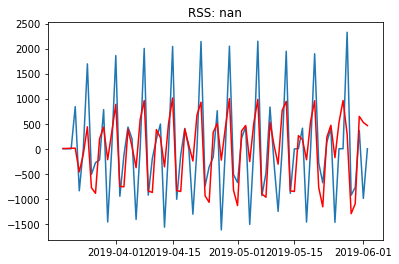

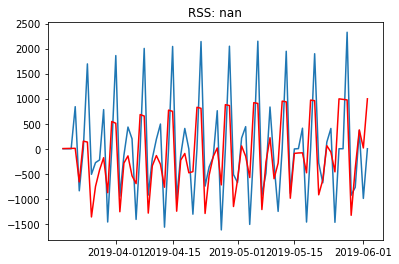

In [122]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_sqrt, order=(3, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))
plt.show()


model = ARIMA(ts_sqrt, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_diff)**2))
plt.show()


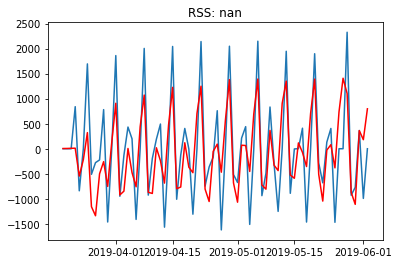

Text(0.5, 1.0, 'RMSE: 670.0218')

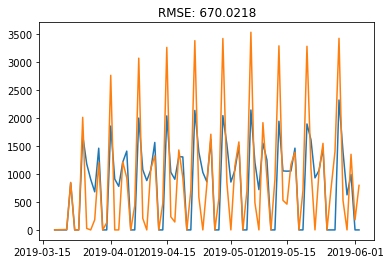

In [127]:

model = ARIMA(ts_sqrt, order=(2, 1,2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_diff)**2))
plt.show()



predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()


ts_predict = ts_sqrt
ts_predict = ts_predict.add(predictions_ARIMA_diff,fill_value=0)
ts_predict[ts_predict < 0] =0

plt.plot(ts)
plt.plot(ts_predict)
plt.title('RMSE: %.4f'% np.sqrt(sum((ts_predict-ts)**2)/len(ts)))


DELIVERY_DATE
2019-03-19     0.173658
2019-03-20     0.208872
2019-03-21     0.417725
2019-03-22     0.505428
2019-03-23   -15.578500
dtype: float64
DELIVERY_DATE
2019-03-19     0.173658
2019-03-20     0.382530
2019-03-21     0.800255
2019-03-22     1.305683
2019-03-23   -14.272817
dtype: float64


Text(0.5, 1.0, 'RMSE: 1241.6835')

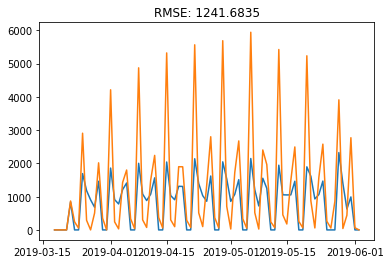